# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — её уже сделали.

Необходимо построить модель с максимально большим значением accuracy. Нужно довести долю правильных ответов по крайней мере до 0.75. Затем надо проверьте accuracy на тестовой выборке.

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
сalls — количество звонков,
minutes — суммарная длительность звонков в минутах,
messages — количество sms-сообщений,
mb_used — израсходованный интернет-трафик в Мб,
is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from random import randint

### Cчитываем данные из файла и сохраняем их в переменную df, получаем общую информацию о датафрейме методом info() и выводим первые 5 строк датафрейма

In [2]:
df = pd.read_csv(r'D:\Мои Документы\Desktop\Материалы по учебе\Введение в машинное обучение\users_behavior.csv')
#df = pd.read_csv('/datasets/users_behavior.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


#### В датасете 3214 строк и 5 столбцов, пропущенных данных нет.

### Методом describe()  и  с помощью посторения гистограм получаем инфоормацию о распределении данных в столбцах 

In [3]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


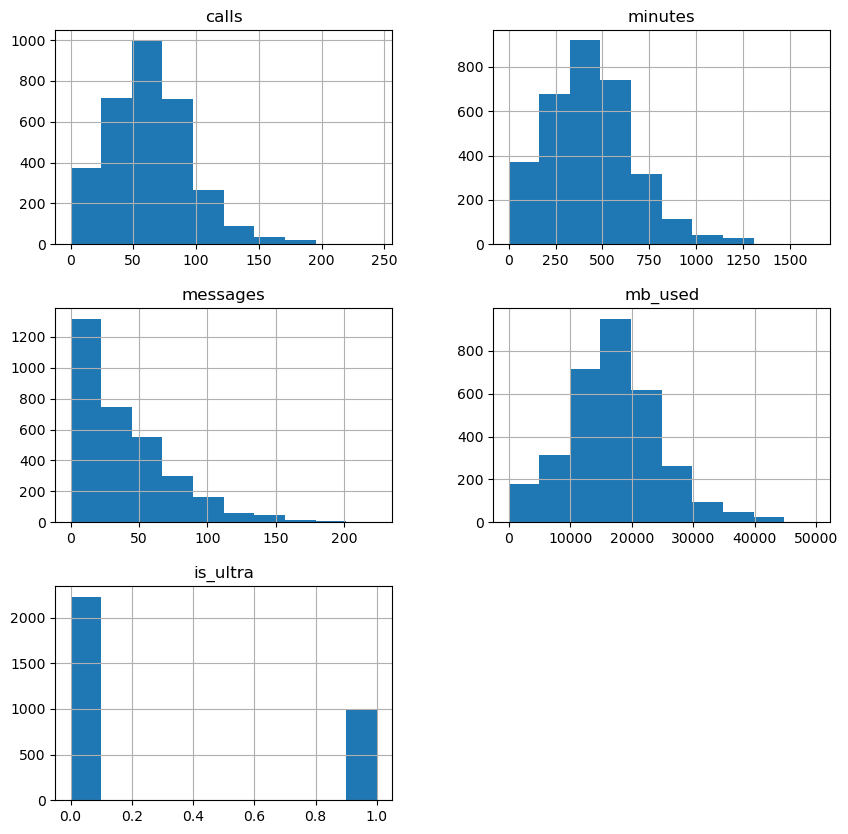

In [5]:
df.hist(figsize=(10, 10));

#### Все распределения выглядят вполне логичными. Людей, использующих тариф "Смарт" в 2 с лишним раза больше, чем людей использующих тариф "Ультра"

## Разбиваем данные на выборки

###  Разделяем исходные данные на три выборки: обучающую (60%), валидационную (20%) и тестовую(20%) с помощью функции train_test_split из sklearn.model_selection

#### Разбиваем датасет df на два датасета features (датасет с признаками) и target (датасет со значениями целевого признака)

In [5]:
features = df.drop(['is_ultra'], axis=1)
features.head()

,calls,minutes,messages,mb_used
0,40.0,311.90,83.0,19915.42
1,85.0,516.75,56.0,22696.96
2,77.0,467.66,86.0,21060.45
3,106.0,745.53,81.0,8437.39
4,66.0,418.74,1.0,14502.75


In [6]:
target = df['is_ultra']
target.head()

0    0
1    0
2    0
3    1
4    0
Name: is_ultra, dtype: int64

#### Разделяем исходные features и target сначала на две выборки: обучающую и выборку, которую будет потом делить на валидационную и тестовую

In [7]:
features_train, features_y, target_train, target_y = train_test_split(features, target, test_size=0.4, random_state=12345 )
print(features_train.shape)
target_train.shape

(1928, 4)


(1928,)

#### Разделяем выборки features_y и target_y на валидационную и тестовую

In [8]:
features_valid, features_test, target_valid, target_test = train_test_split(features_y, target_y, test_size=0.5, 
                                                                            random_state=12345 )
print(features_valid.shape)
print(features_test.shape)
print(target_valid.shape)
target_test.shape

(643, 4)
(643, 4)
(643,)


(643,)

In [9]:
target_train.value_counts()

0    1335
1     593
Name: is_ultra, dtype: int64

In [10]:
target_valid.value_counts()

0    454
1    189
Name: is_ultra, dtype: int64

In [11]:
target_test.value_counts()

0    440
1    203
Name: is_ultra, dtype: int64

##  Исследуем модели

### Исследуем модель решающее дерево.

#### Самый важный параметр для решающего дерева, глубина дерева, попробуем поменять величину max_depth с 1 до 10 и min_samples_leaf  от 1 до 6. Запомнить лучшую модель.

In [12]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
best_min_samples_leaf = 0
for depth in range (1,11):
    for leaf in range (1,6):
        model_1 = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_split=2, min_samples_leaf=leaf)
        model_1.fit(features_train, target_train)
        predictions = model_1.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        if result > best_result_tree:
            best_model_tree = model_1
            best_result_tree = result
            best_depth_tree = depth
            best_min_samples_leaf = leaf
f'Accuracy лучшей модели: {best_result_tree}, глубина дерева: {best_depth_tree}, best_min_samples:{best_min_samples_leaf}' 


'Accuracy лучшей модели: 0.7869362363919129, глубина дерева: 6, best_min_samples:4'

####  Задавала разные интервалы изменения глубины дерева, получила наилучший результат на глубине дерева 3 -  0.7853810264385692. Затем еще добавила гиперпараметры min_samples_split и  min_samples_leaf, за счет изменения параметра min_samples_leaf до 4, чуть улучшила модель. Так как по условиям задания доля правильных ответов должна быть не менее 0.75 решила проверить эту модель на тестовой выборке.

### Исследуем модель решающий лес

#### Подбираем наиболее оптимальное значение гиперпараметров n_estimators и max_depth 

In [13]:
best_model_forest = None
best_result_forest = 0
best_depth_forest = 0
best_est = 0
for est in range (10,101,10):
    for depths in range (1,11):
        model_2 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depths)
        model_2.fit(features_train, target_train)
        predictions_forest = model_2.predict(features_valid)
        result_2 = accuracy_score(target_valid, predictions_forest)
        if result_2 > best_result_forest:
            best_model_forest = model_2
            best_result_forest = result_2
            best_depth_forest = depths
            best_est = est
f'Accuracy лучшей модели: {best_result_forest}, глубина дерева: {best_depth_forest}, число деревьев {best_est}' 

'Accuracy лучшей модели: 0.8087091757387247, глубина дерева: 8, число деревьев 40'

Получила лучший результат на глубине дерева 8 и числе деревьев 40, результат выше, чем на у модели 'Решающее дерево', скорость ниже.  Полученный результат соответсвует задаче, протестируем данную модель на тестовой выборке.

#### Добавим еже 1 параметр min_samples_split в диапазоне от 2 до 6.

In [14]:
best_model_forest_2 = None
best_result_forest_2 = 0
best_depth_forest_2 = 0
best_est_2 = 0
for est_2 in range (10,101,10):
    for depth_2 in range (1,11):
        for split in range (2,6):
            model_2f = RandomForestClassifier(random_state=12345, n_estimators=est_2, max_depth=depth_2, 
                                          min_samples_split=split, min_samples_leaf=1, criterion='gini')
            model_2f.fit(features_train, target_train)
            predictions_forest_2 = model_2f.predict(features_valid)
            result_2f = accuracy_score(target_valid,  predictions_forest_2)
            if result_2f > best_result_forest_2:
                best_model_forest_2 = model_2f
                best_result_forest_2 = result_2f
                best_depth_forest_2 = depth_2
                best_est_2 = est_2
                best_split = split
f'Accuracy лучшей модели: {best_result_forest_2}, глубина дерева: {best_depth_forest_2}, число деревьев {best_est_2}, min_samples_split {split}' 

'Accuracy лучшей модели: 0.8102643856920684, глубина дерева: 7, число деревьев 40, min_samples_split 5'

Получили результат лучше - 'Accuracy лучшей модели: 0.8102643856920684, глубина дерева: 7, число деревьев 40, min_samples_split 5'

### Исследуем модель логистичекская регрессия

#### Здесь попробуем менять решающий алгоритм и число итераций 

In [15]:
best_model_logistic = None
best_result_logistic = 0
best_max_iter = 0
solvers = ['lbfgs', 'liblinear'] 
for solv in solvers:
    for iteration in (100, 1101, 100):
        model_3 = LogisticRegression(random_state=12345, solver=solv, max_iter=iteration, penalty='l2')
        model_3.fit(features_train, target_train)
        result_3 = model_3.score(features_valid, target_valid)
        if result_3 > best_result_logistic:
            best_model_logistic = model_3
            best_result_logistic =  result_3
            best_max_iter = iteration
            best_solvers = solv

f'Accuracy лучшей модели: {best_result_logistic}, количество итераций: {best_max_iter}, solver лучшей модели: {best_solvers}' 

'Accuracy лучшей модели: 0.7107309486780715, количество итераций: 100, solver лучшей модели: lbfgs'

Так как варианты penalty l1 и l2  возможны только у решающего алгоритма 'liblinear' из рассмотренных выше, то меняю этот парметр ниже    


In [16]:
best_model_logistic_2 = None
best_result_logistic_2 = 0
best_max_iter_2 = 0
penaltys = ['l1', 'l2'] 
for penaltys in penaltys:
    for iterations in (100, 1101, 100):
        model_regression = LogisticRegression(random_state=12345, solver='liblinear', max_iter=iterations, penalty=penaltys)
        model_regression.fit(features_train, target_train)
        result_4 = model_regression.score(features_valid, target_valid)
        if result_4 > best_result_logistic_2:
            best_model_logistic_2 = model_regression
            best_result_logistic_2 =  result_4
            best_max_iter_2 = iterations
            best_penaltys = penaltys

f'Solver: liblinear, Accuracy лучшей модели: {best_result_logistic_2}, количество итераций: {best_max_iter_2}, penalty лучшей модели: {best_penaltys}' 

'Solver: liblinear, Accuracy лучшей модели: 0.7573872472783826, количество итераций: 100, penalty лучшей модели: l1'

Качество модели с такими значениями гиперпараметров стало лучше.

#### Качество данной модели не устраивает, не будем ее тестировать на тестовой выборке

## Проверяем качество моделей на тестовой выборке

### Проверяем качество модели решающее дерево на тестовой выборке

In [17]:
result_tree_test = best_model_tree.score(features_test, target_test)
result_tree_test

0.7791601866251944

### Проверяем качество модели случайный лес на тестовой выборке

In [19]:
resalt_forest_test_2 = best_model_forest_2.score(features_test, target_test) 
resalt_forest_test_2    

0.8009331259720062

#### Проверив результаты работы моделей на тестовой выборке, получили следующие результаты:
Качество работы модели "Случайный лес" на тестовой выборке чуть лучше, чем качество работы модели "Решающее дерево", доля правильный ответов составляет 0.796, а доля правильных ответов модели "Рещающее дерево" - 0.801. Поэтому вибираем модель "Случайный лес".

## Проверяем модель "Случайный лес" на вменяемость


Для проверки модели сравниваем ее со случайной моделью, которая предсказывает все объекты случайным образом, т.е. с вероятностью 50/50 ответ будет 0 или 1. Для этого создаем Series со случайными значениями (0,1) величиной с тестовую выборку. Сравним эти значения с ответами тестовой выборки.

In [20]:
a = []
for i in range(len(target_test)):
    b = randint(0,1)
    a.append(b)
a = pd.Series(a)
print(a.shape)
a.value_counts()   

(643,)


1    323
0    320
dtype: int64

In [21]:
accuracy = accuracy_score(target_test, a)
accuracy

0.4867807153965785

Проверим на вменяемость при помощи модели DummyClassifier

In [22]:
from sklearn.dummy import DummyClassifier

model_const = DummyClassifier(strategy="most_frequent", random_state=12345)
model_const.fit(features_train, target_train)
accuracy_const = model_const.score(features_test, target_test)
accuracy_const

0.6842923794712286

#### При сравнении с данной моделью качество модели "Случайный лес" также выше, следовательно модель вменяемая

### Итоговый вывод:
1. Изучив данные о поведении клиентов, которые уже перешли на тарифы "Самарт" и "Ультра", увидели что пропусков в данных нет, распределения значений в столбцах выглядят логичными, количество клиентов, использующих тариф "Самарт" больше, чем в 2 раза превышает количество клиентов, использующих тариф "Ультра".
2. Провели обучение трех моделей и получили следующие результы оценки их качества на валидационной выборке:
Модель "Решающее дерево" - 0.79 
Модель "Случайный лес" - 0.81
Модель "Логистическая регрессия - 0.71
Для тестирования моделей на тестовой выборке были выбраны две модели "Решающее дерево" и "Случайный лес", т.к. их значения качества давольно близкие и соответсвует изначальной задаче.
3. Провели тестирование обученных моделей на тестовой выборке и получили следующие результтаты качества моделей. 
Модель "Решающее дерево" - 0.78 
Модель "Случайный лес" - 0.8
Такимм образом, модель "Случайный лес" показала наилучшие результаты по качеству модели.
4. Проверели модель "Случайный лес" на вменяемость путем сравнения показателей ее качества и качества случайной модели (предсказывает все объекты случайным образом, т.е. с вероятностью 50/50 ответ будет 0 или 1). Качество случайной модели (0.51)  хуже, чем качество модели "Случайный лес" (0.8), соответсвенно модель вменяемая.